In [1]:
import pandas as pd
import numpy as np

import json
import codecs

from tqdm.notebook import tqdm

In [2]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = './drive/MyDrive/Colab Notebooks/Hackathon/data'

Mounted at /content/drive


# Load raw data and preprocess

In [4]:
with codecs.open(f'{data_dir}/ranking_train.jsonl', encoding='utf-8', mode='r') as f:
    lines = f.readlines()
    q_ds_list = [json.loads(line) for line in lines]

In [5]:
import html
query = []
documents = []
scores = []
for q_ds in q_ds_list:
    query.append(html.unescape(q_ds['text']))
    ds = [com['text'] for com in q_ds['comments']]
    for com in q_ds['comments']:
        documents.append(html.unescape(com['text']))
        scores.append(com['score'])

scores = (4 - np.array(scores))
torch.save(torch.Tensor(scores), f'{data_dir}/scores.pt')

In [6]:
# data sample
query_ind = 1
print("Query:")
print(query[query_ind])
print()
print("Score, comments:")
list(zip(scores[query_ind*5:query_ind*5+5], documents[query_ind*5:query_ind*5+5]))

Query:
CBS acquires last.fm for $280m

Score, comments:


[(4,
  "It will be curious to see where this heads in the long run.  CBS is on a tear but will it fit their image, will they try and establish control, overall agenda.  I've enjoyed last.fm for many years supporting through paypal donations each time I expire...it'll be interesting."),
 (3,
  "Does this mean that there's now a big-name company who will fight for the repeal of the recent streaming-music royalty hike?"),
 (2,
  'Also on BBC News:  http://news.bbc.co.uk/1/low/technology/6701863.stm .Nice to see a London-based co. hit the headlines.'),
 (1, "I don't understand what they do that is worth $70M a year. "),
 (0,
  'sold out too cheaply. given their leadership position, they should have ask for at least $500m')]

### Feature Engineering

In [ ]:
!pip install py-readability-metrics
!python -m nltk.downloader punkt

In [ ]:
import re
features_df = pd.DataFrame()
''' primary features '''
features_df['chars_num'] =     [len(d) for d in documents]
features_df['cap_chars_num'] = [len(re.findall(r"[A-Z]", d)) for d in documents]
features_df['digits_num'] =   [len(re.findall(r"[0-9]", d)) for d in documents]
features_df['words_num'] =     [len(d.split()) for d in documents]
features_df['cap_words_num'] = [sum(map(str.isupper, d.split())) for d in documents]
features_df['unique_words_num'] = [len(set(d.split())) for d in documents]
features_df['sentences_num'] = [len(re.findall(r"[^.!?]+", d)) for d in documents]
features_df['http_num'] = [len(re.findall(r"http", d)) for d in documents]
''' secondary features '''
features_df['unique_vs_words'] = features_df['unique_words_num'] / features_df['words_num']
features_df['avg_wordlength'] = features_df['chars_num'] / features_df['words_num']
features_df['avg_sentencelength'] = features_df['words_num'] / features_df['sentences_num']
# Readability (https://pypi.org/project/py-readability-metrics/)
features_df['ARI'] = 4.71 * features_df['chars_num']/features_df['words_num'] \
                   + 0.5 * features_df['words_num']/features_df['sentences_num'] - 21.43

In [ ]:
''' sentiment features '''
from textblob import TextBlob
sentiment_polarity = []
sentiment_subjectivity = []
for d in tqdm(documents):
      sentiment = TextBlob(d).sentiment
      sentiment_polarity.append(sentiment.polarity)
      sentiment_subjectivity.append(sentiment.subjectivity)
features_df['polarity'] = sentiment_polarity
features_df['subjectivity'] = sentiment_subjectivity
features_df

  0%|          | 0/440535 [00:00<?, ?it/s]

,chars_num,cap_chars_num,digits_num,words_num,cap_words_num,unique_words_num,sentences_num,http_num,unique_vs_words,avg_wordlength,avg_sentencelength,ARI,polarity,subjectivity
0,998,12,2,181,0,120,12,0,0.662983,5.513812,15.083333,12.081722,-0.042308,0.447436
1,414,4,0,76,0,61,4,0,0.802632,5.447368,19.000000,13.727105,0.172222,0.325000
2,488,28,0,91,5,71,6,0,0.780220,5.362637,15.166667,11.411355,0.190303,0.408788
3,318,7,2,64,2,48,4,0,0.750000,4.968750,16.000000,9.972812,0.176190,0.509524
4,81,1,0,14,1,13,1,0,0.928571,5.785714,14.000000,12.820714,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440530,582,2,3,73,0,54,10,3,0.739726,7.972603,7.300000,19.770959,0.150000,0.495563
440531,265,2,12,48,0,44,5,0,0.916667,5.520833,9.600000,9.373125,0.420000,0.540000
440532,245,5,0,44,0,42,5,0,0.954545,5.568182,8.800000,9.196136,0.045833,0.606944
440533,188,7,4,31,1,30,4,0,0.967742,6.064516,7.750000,11.008871,-0.025000,0.125000


In [ ]:
''' save features '''
features_df.to_csv(f'{data_dir}/features.csv')

### Make BERT embeddings

In [ ]:
%pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel, AutoModel

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

query_tokenized = []
documents_tokenized = []
for q in tqdm(query[:100]):
    query_tokenized.append(tokenizer(q, return_tensors='pt').to(device))
for d in tqdm(documents[:500]):
    documents_tokenized.append(tokenizer(d, return_tensors='pt').to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
"Before tokenization: ", documents[25], \
"After tokenization: ", tokenizer.decode(documents_tokenized[25]['input_ids'].squeeze())

('Before tokenization: ',
 'I smell bullshit. Note from the article:> Companies are having a hard time recruiting and retaining young talent, and as a result are accommodating what would have once been considered extreme demands. ....so many younger workers have gained the advantage when it comes to negotiating the terms of a new job.and > Today, however, economists and sociologists see such homecomings as a rational response to exorbitant housing prices in big cities, and entry-level wages that do not cover living expenses.So which is it? Employers can\'t find employees, or the labor market is so oversaturated in big cities that entry level positions don\'t pay living wages?My guess is that every company only wants to hire "the top 5% of graduates." So competition for the perceived best (ivy league, specialized skills) grows while Joe State and Cathy Community go chill with the folks and work at Walmart.EDIT: how do you make block quotes?',
 'After tokenization: ',
 '[CLS] I smell bul

In [ ]:
for i in tqdm(range(len(query_tokenized))):
    for key in query_tokenized[i].keys():
        query_tokenized[i][key] = query_tokenized[i][key][:, :512]
    query_tokenized[i]['input_ids'][:, -1] = 102  # set last token as [SEP] if it was cut off
for i in tqdm(range(len(documents_tokenized))):
    for key in documents_tokenized[i].keys():
        documents_tokenized[i][key] = documents_tokenized[i][key][:, :512]
    documents_tokenized[i]['input_ids'][:, -1] = 102  # set last token as [SEP] if it was cut off
query_tokenized[0]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

{'input_ids': tensor([[  101,  1731,  1242,  2247,   162,  3291, 12913, 24682,  5841,  8870,
          1879,  1136,  1106,  2760,  1114,  1147,  1838,  4455,  1105,  1301,
          1171,  1106,  1278,   136,  1105,  1184,  1127,  1103,  3672,   136,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
model = BertModel.from_pretrained("bert-base-cased")
model = model.eval()
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
query_embedding = []
documents_embedding = []
with torch.no_grad():
    for q in tqdm(query_tokenized):
        query_embedding.append(model(**q, return_dict=False)[1])
    for d in tqdm(documents_tokenized):
        documents_embedding.append(model(**d, return_dict=False)[1])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# save embeddings
for i in tqdm(range(len(query_embedding))):
    query_embedding[i] = query_embedding[i].to('cpu')
for i in tqdm(range(len(documents_embedding))):
    documents_embedding[i] = documents_embedding[i].to('cpu')
query_embedding = torch.stack(query_embedding)
documents_embedding = torch.stack(documents_embedding)
torch.save(query_embedding, f'{data_dir}/query_embedding.pt')
torch.save(documents_embedding, f'{data_dir}/documents_embedding.pt')

### Make better embeddings

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# check embeddings in terms of semantic proximity
sentences = ["My phone is not good.",
             "Your cellphone looks great.",
             "Will it snow tomorrow?",
             "Recently a lot of hurricanes have hit the US",
             "An apple a day, keeps the doctors away",
             "Eating strawberries is healthy"]

# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)

<Axes: >

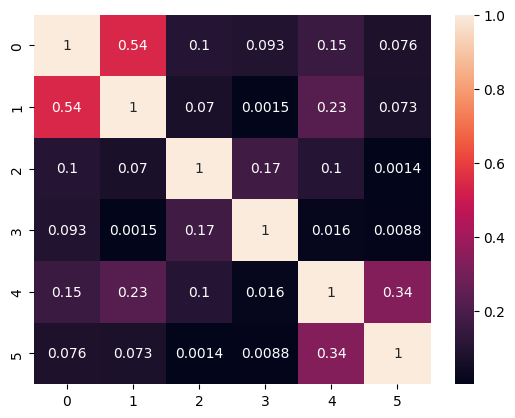

In [ ]:
sns.heatmap(cosine_similarity(embeddings), annot=True)

In [ ]:
# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
query_embeddings = model.encode(query, show_progress_bar=True)
np.save(f'{data_dir}/query_embeddings.npy', query_embeddings)
documents_embeddings = model.encode(documents, show_progress_bar=True)
np.save(f'{data_dir}/documents_embeddings.npy', documents_embeddings)

0it [00:00, ?it/s]

<Axes: >

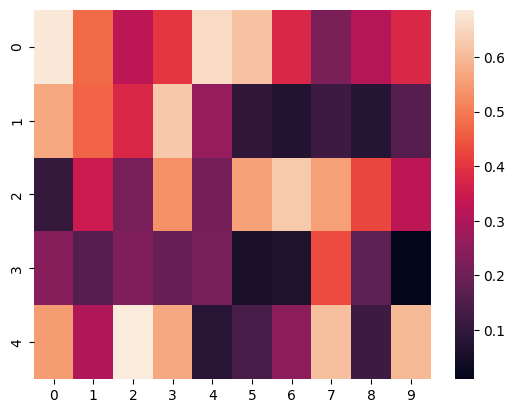

In [ ]:
'''
semantic proximity of posts (queries) and their comments (documents),
number of the ordered comment (document) v.s. post (query) number
'''
query_cos_sim = [cosine_similarity([d], [query_embeddings[i//5]]) for i, d in tqdm(enumerate(documents_embeddings))]
query_cos_sim_m = np.array(query_cos_sim).reshape(5, 10)
sns.heatmap(query_cos_sim_m[:, :10])

In [ ]:
# compute cosine_similarity between query and document (use embeddings)
from sklearn.metrics.pairwise import cosine_similarity
query_cos_sim = [cosine_similarity([d], [query_embedding[i//5]]) for i, d in tqdm(enumerate(documents_embedding))]
features_df['query_cos_sim'] = [i[0][0] for i in query_cos_sim]

0it [00:00, ?it/s]

In [ ]:
''' save features with query_cos_sim '''
features_df.to_csv(f'{data_dir}/features.csv')

# Load preprocessed data

In [7]:
''' read features '''
features_df = pd.read_csv(f'{data_dir}/features.csv', index_col=0)
features_df.head()

,chars_num,cap_chars_num,digits_num,words_num,cap_words_num,unique_words_num,sentences_num,http_num,unique_vs_words,avg_wordlength,avg_sentencelength,ARI,polarity,subjectivity,query_cos_sim
0,998,12,2,181,0,120,12,0,0.662983,5.513812,15.083333,12.081722,-0.042308,0.447436,0.650387
1,414,4,0,76,0,61,4,0,0.802632,5.447368,19.000000,13.727105,0.172222,0.325000,0.521176
2,488,28,0,91,5,71,6,0,0.780220,5.362637,15.166667,11.411355,0.190303,0.408788,0.388382
3,318,7,2,64,2,48,4,0,0.750000,4.968750,16.000000,9.972812,0.176190,0.509524,0.432402
4,81,1,0,14,1,13,1,0,0.928571,5.785714,14.000000,12.820714,0.000000,0.000000,0.558688


### Some Data Analysis

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
query_num = 88107
np.random.seed(42)
mask = (np.random.rand(query_num) < 0.002)

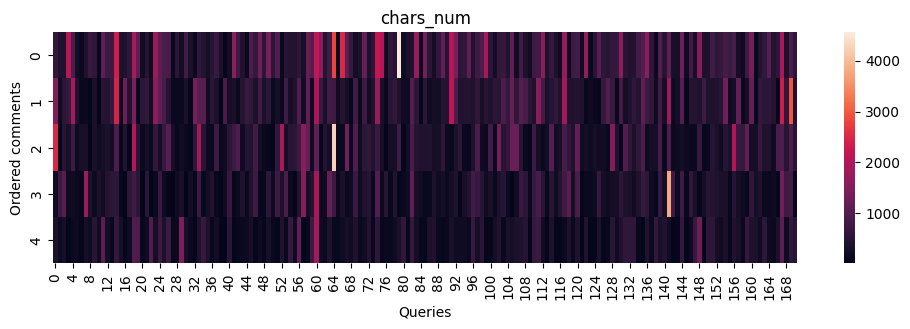

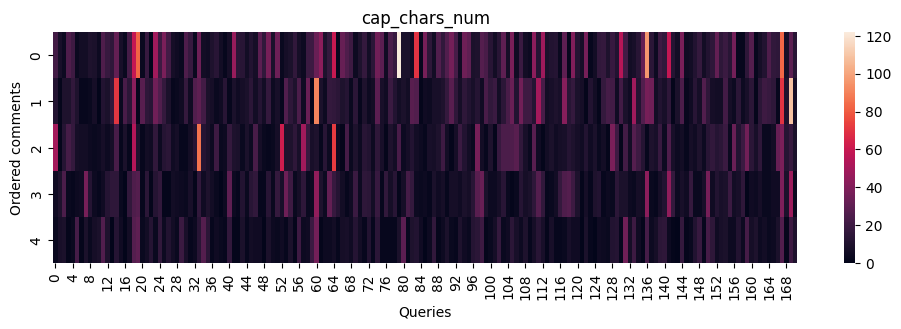

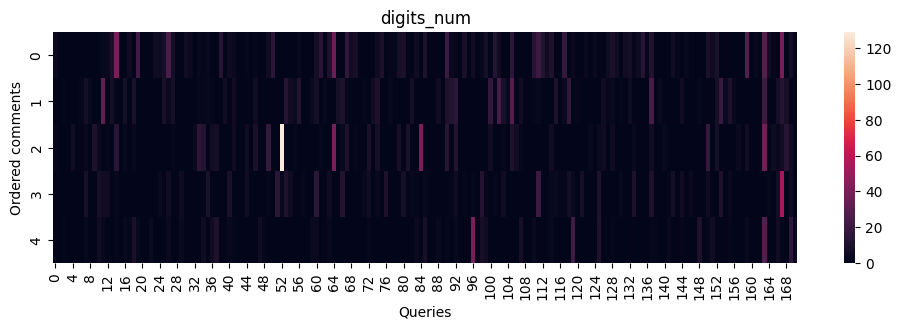

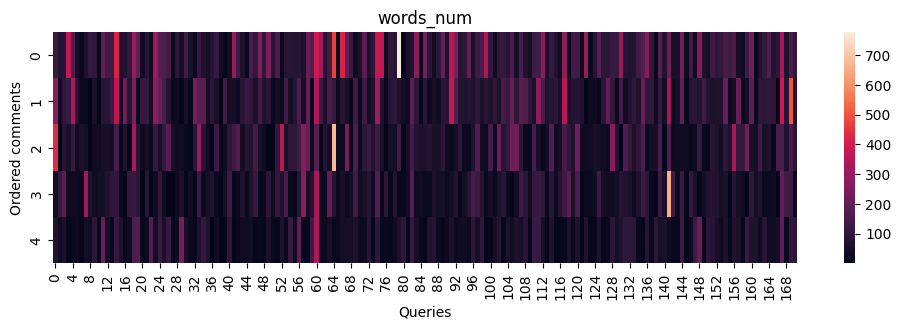

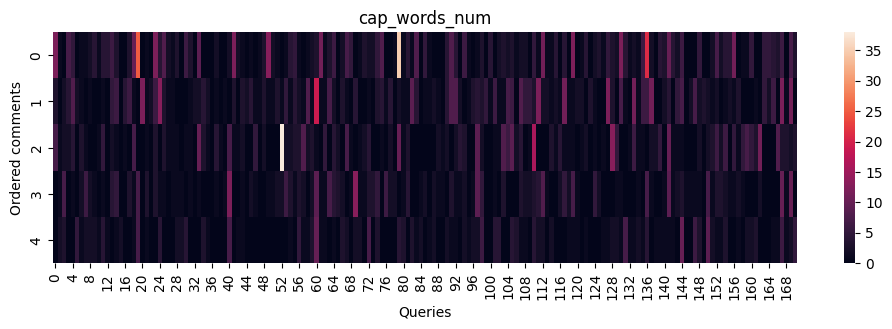

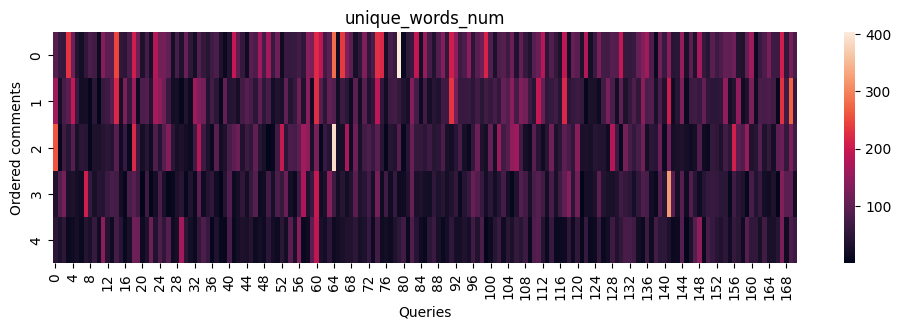

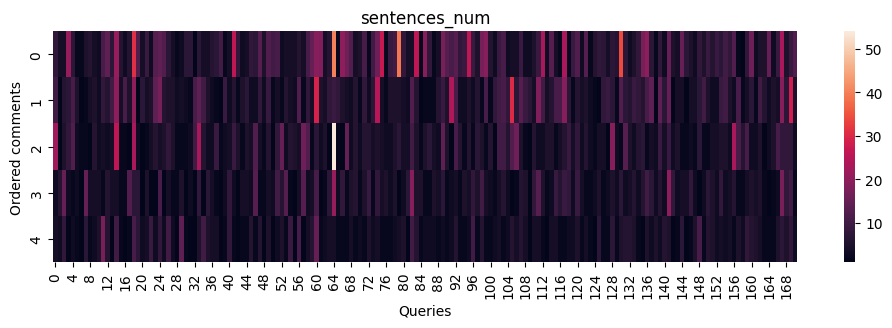

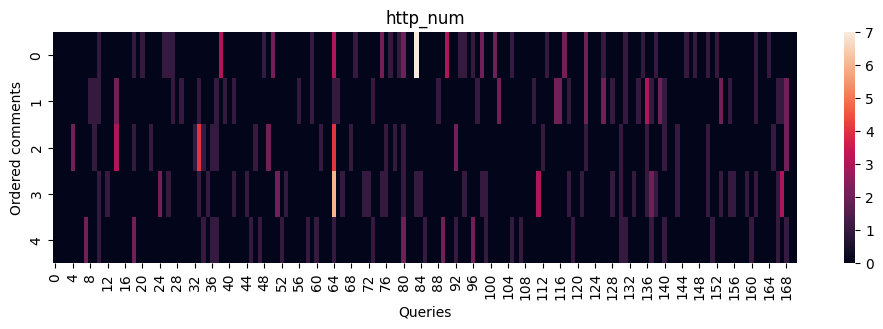

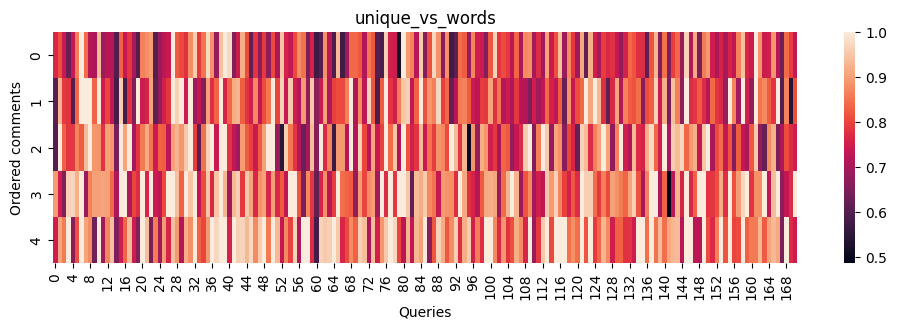

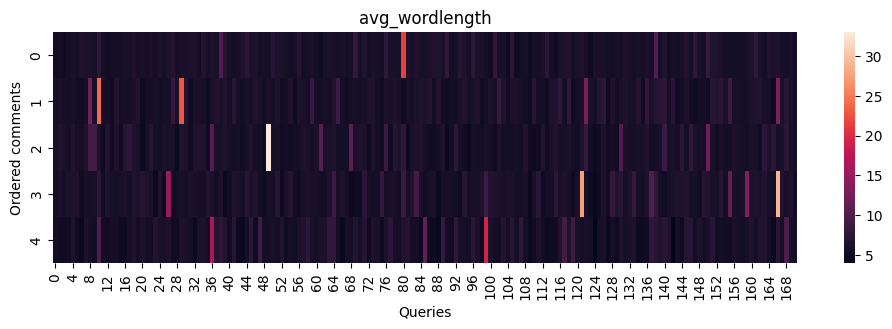

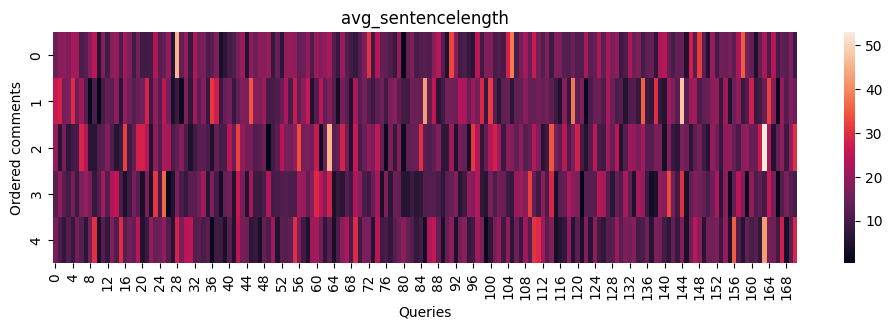

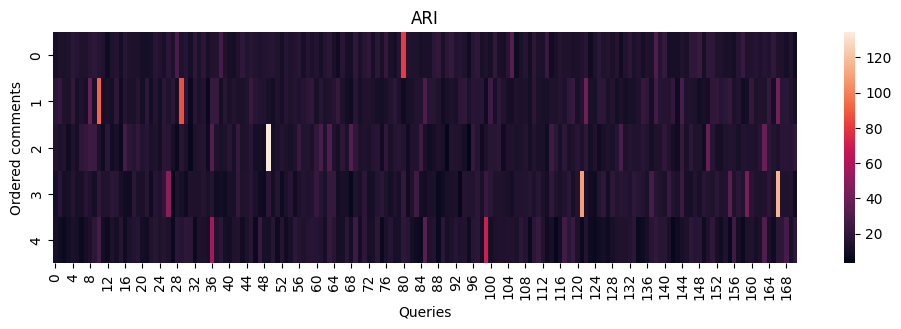

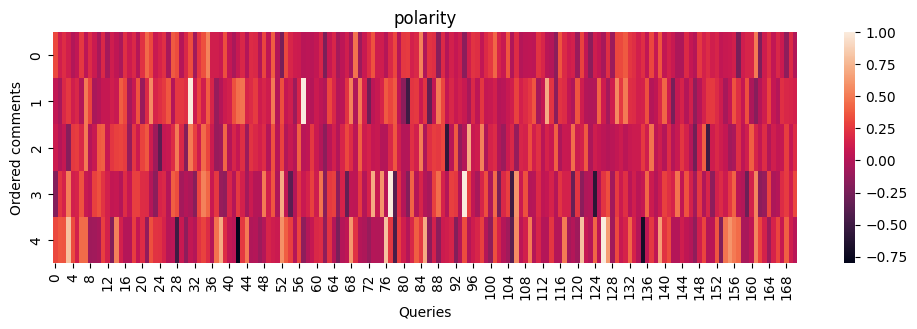

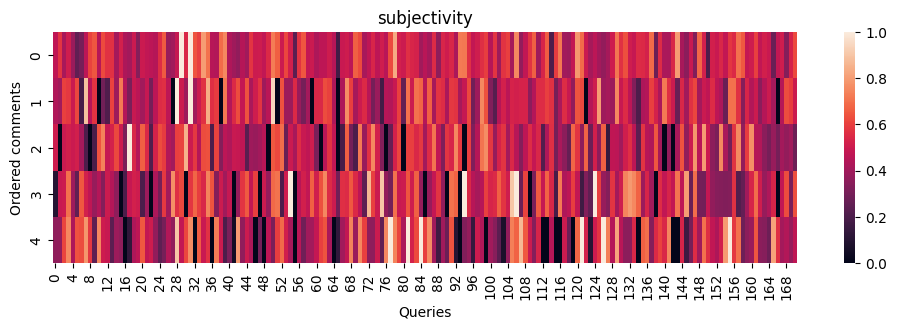

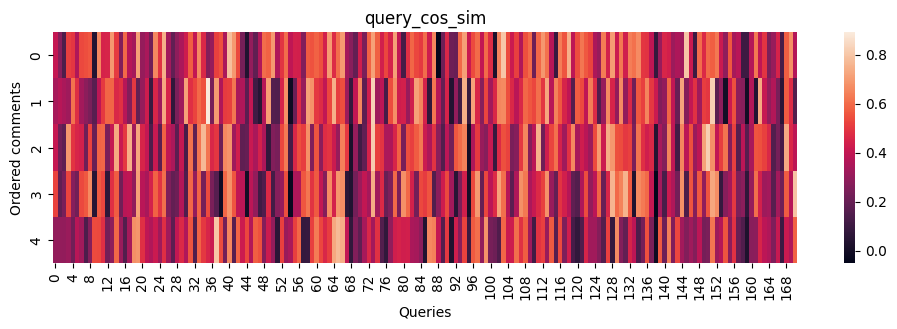

In [14]:
'''
dependence of the order of the comment on the feature
(number of the ordered comment (document) v.s. post (query) number)
'''
for feature_name in features_df.columns:
    plt.figure(figsize=(12,3))
    feature = np.array(features_df[feature_name]).reshape(query_num, 5)
    p = sns.heatmap(feature[mask].T)
    p.set_title(feature_name)
    plt.xlabel("Queries")
    plt.ylabel("Ordered comments")
    plt.savefig(f'{data_dir}/plots/heatmap_features/{feature_name}.png')

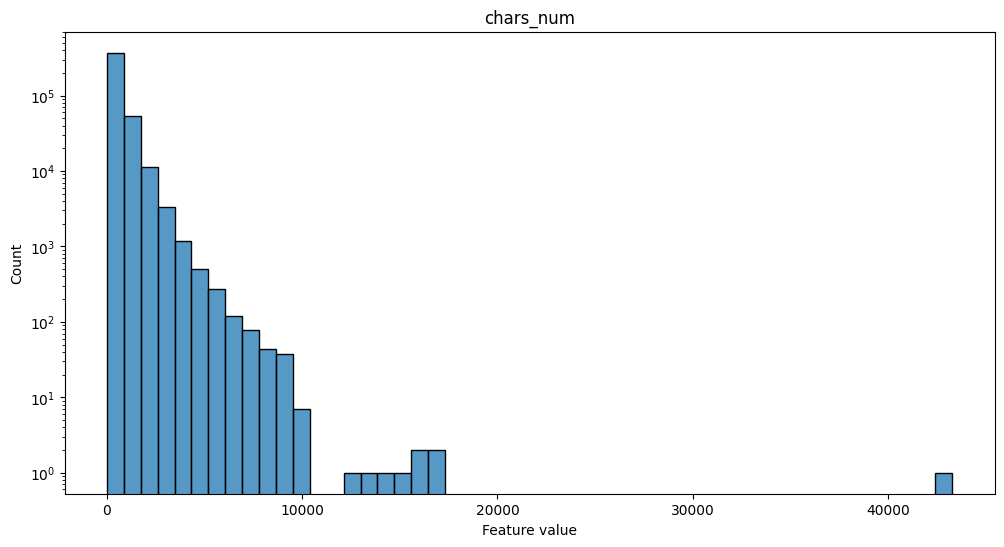

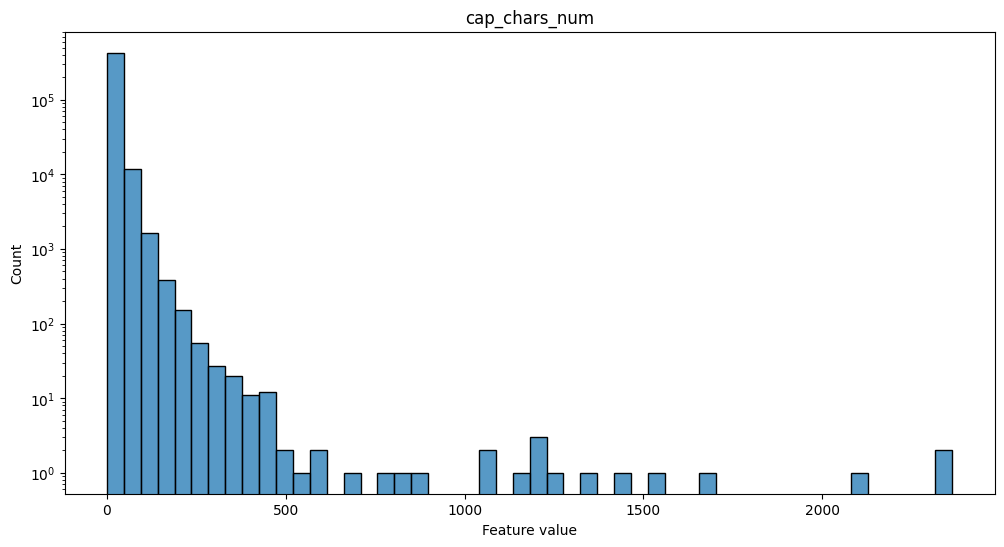

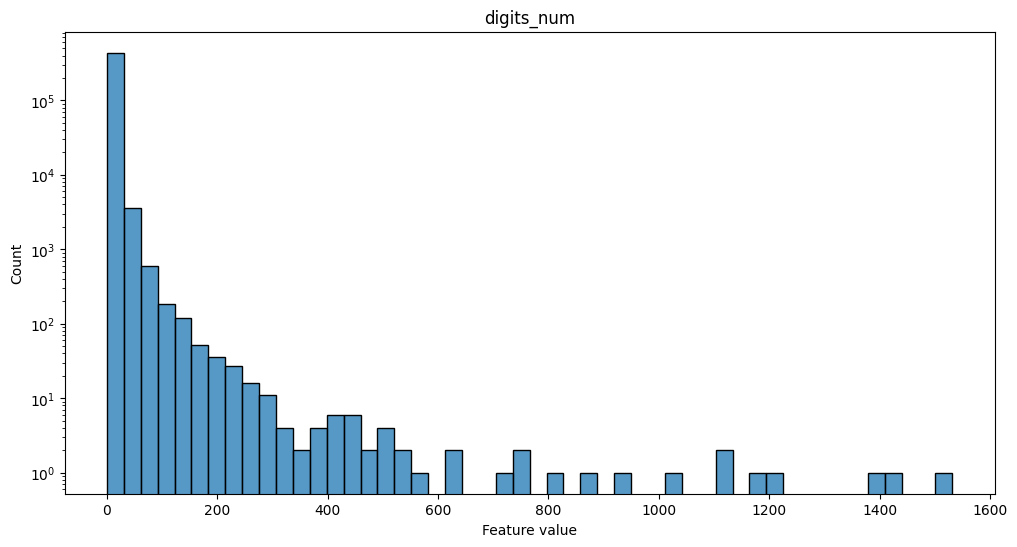

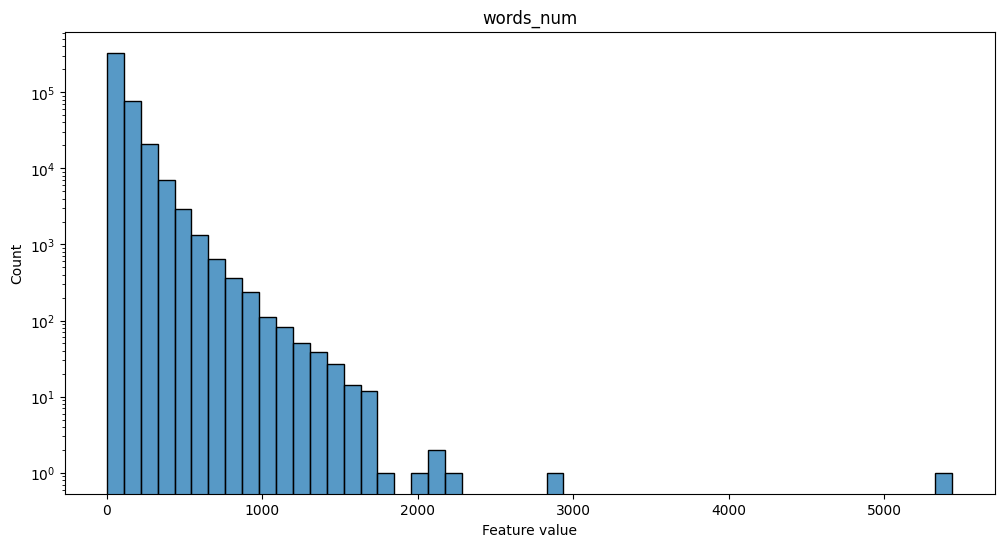

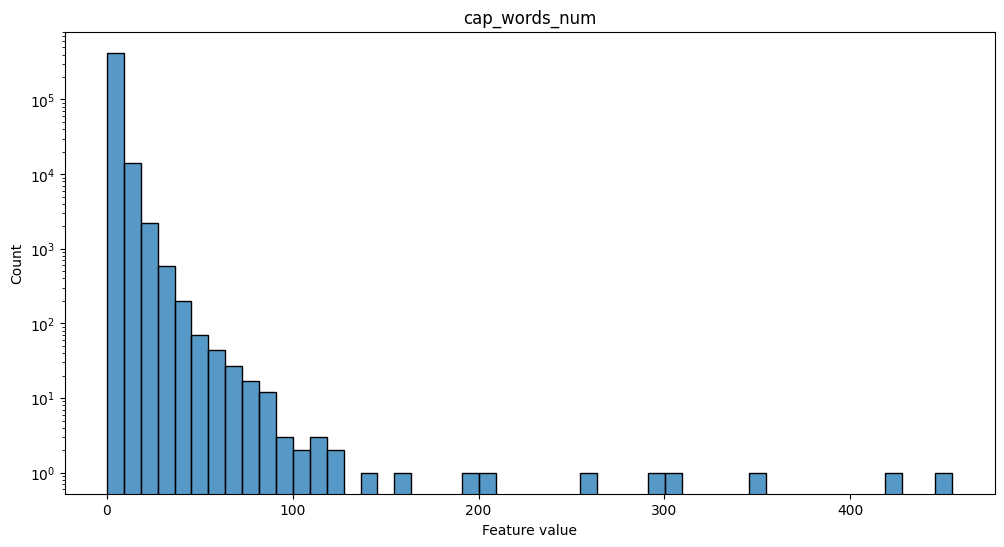

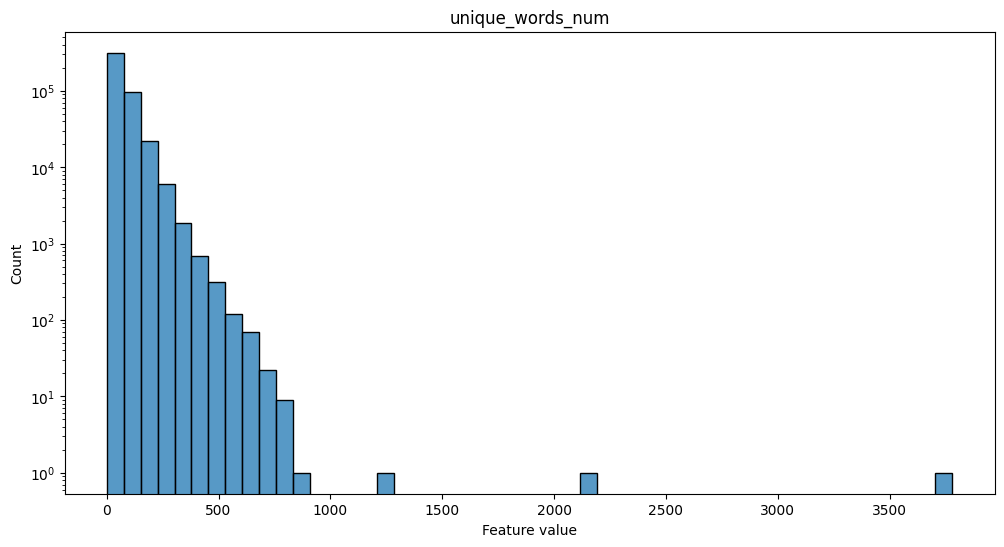

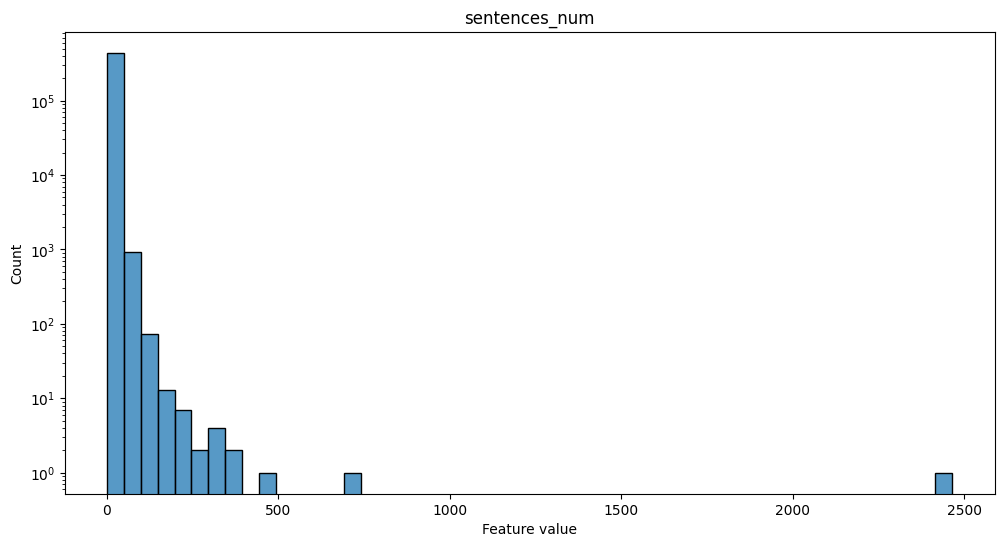

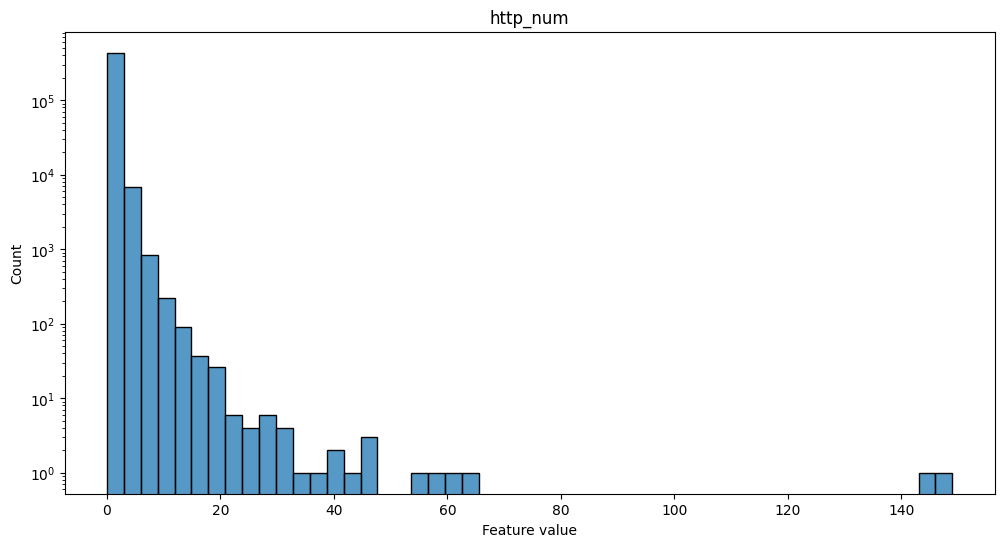

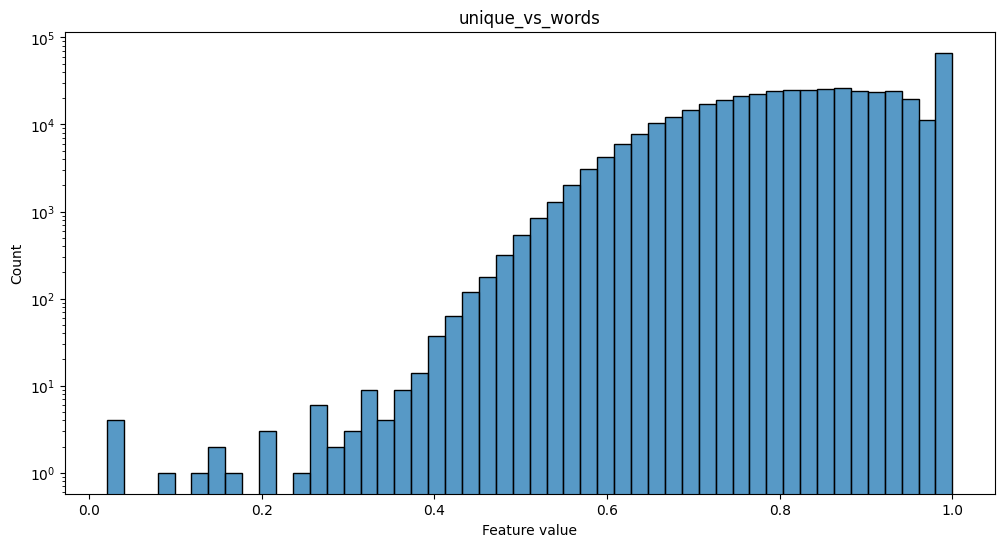

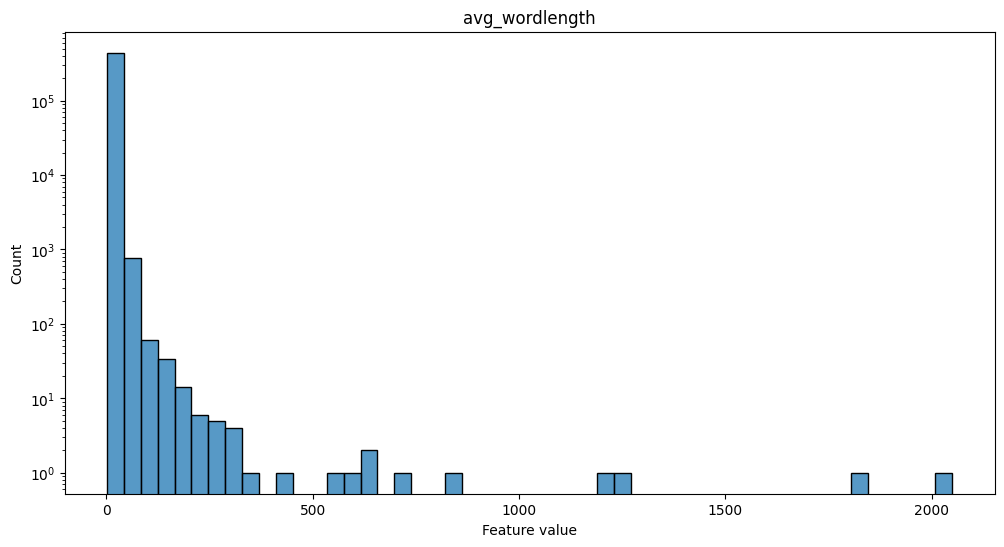

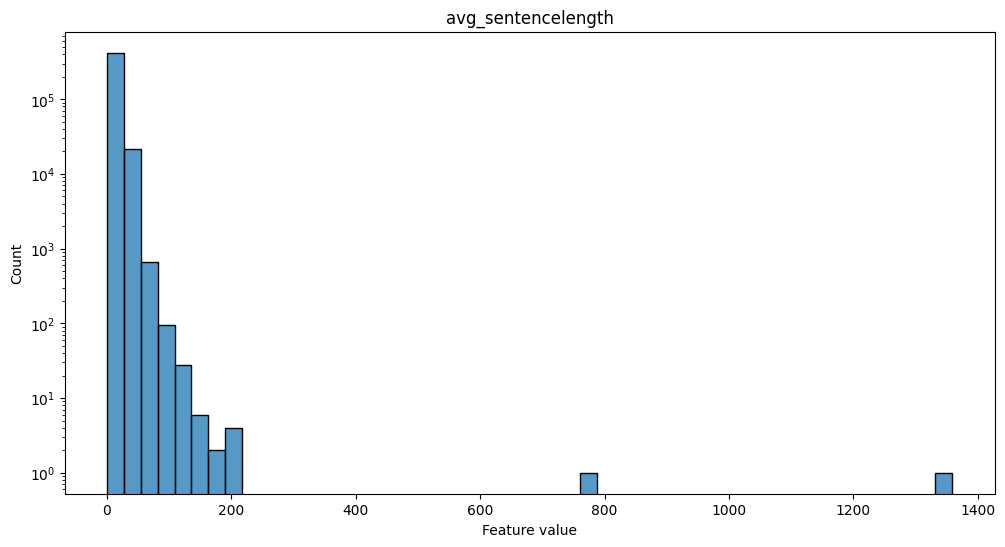

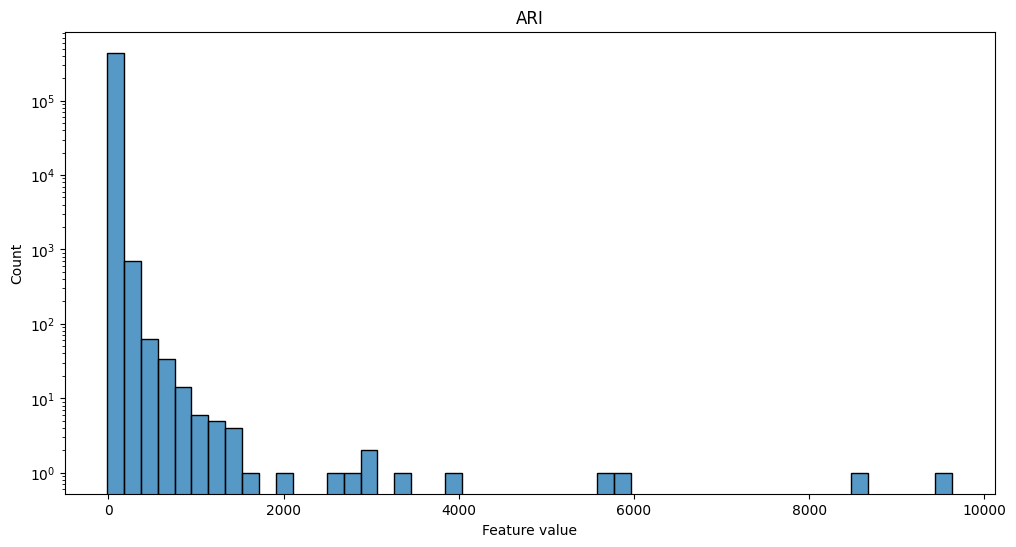

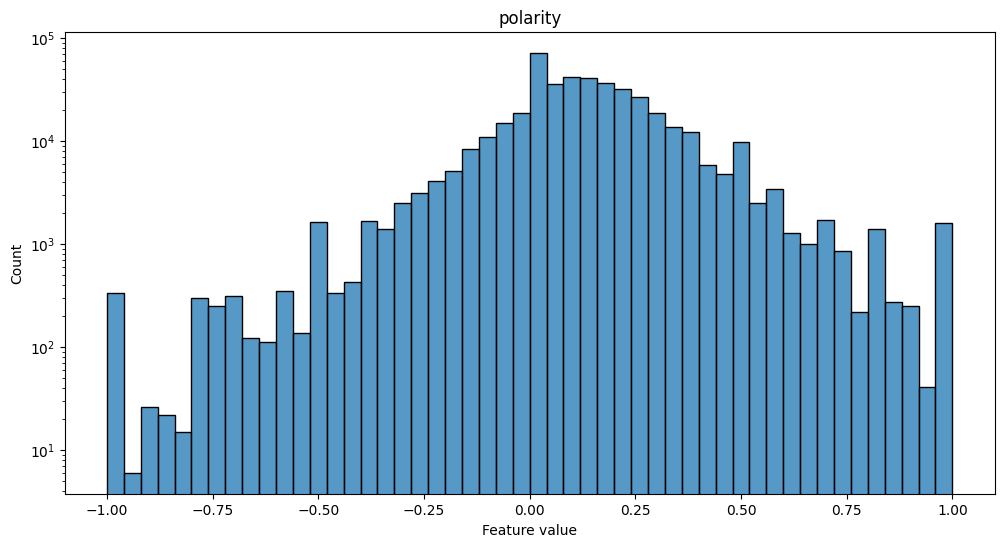

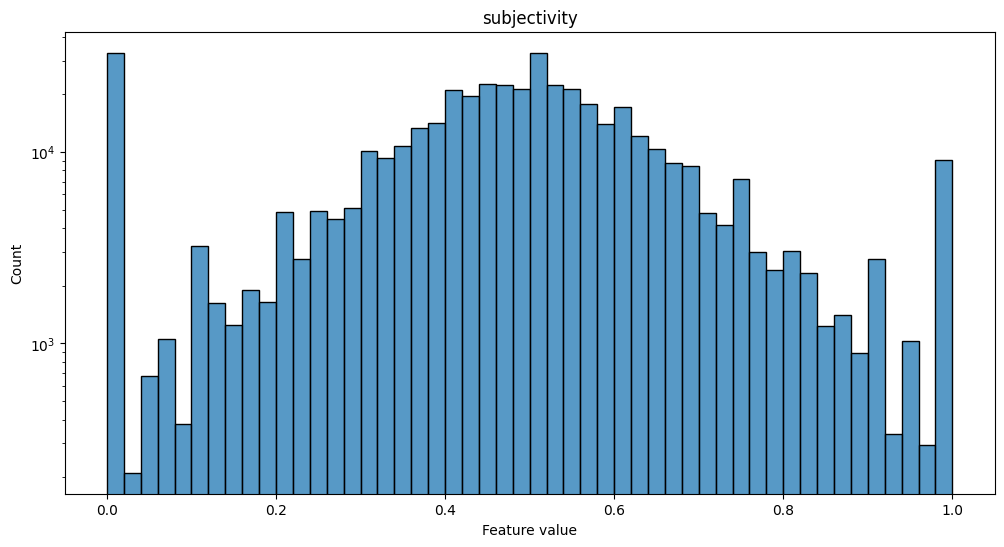

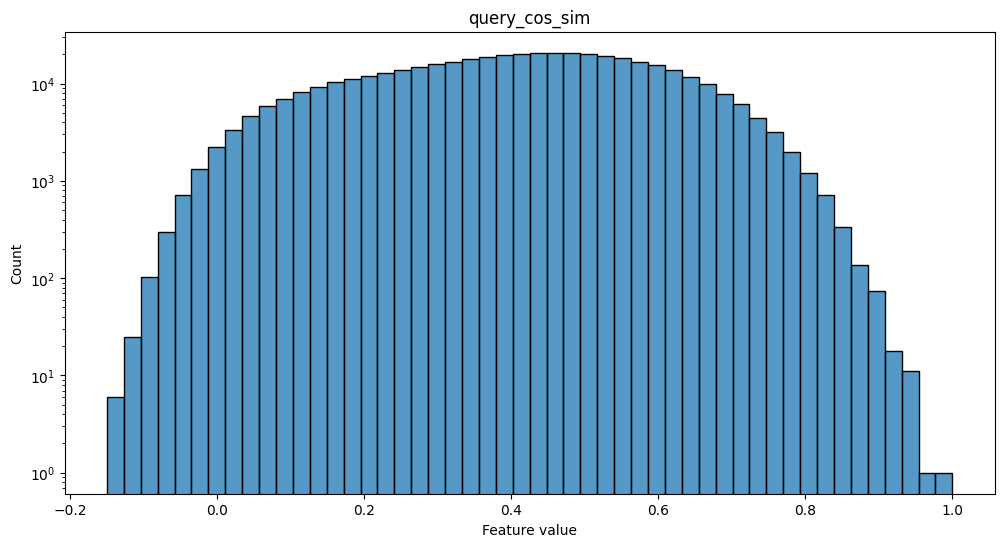

In [16]:
''' distributions of feature values '''
for feature_name in features_df.columns:
    plt.figure(figsize=(12,6))
    feature = np.array(features_df[feature_name])
    p = sns.histplot(feature, bins=50)
    p.set_title(feature_name)
    p.set(yscale="log")
    plt.xlabel("Feature value")
    plt.savefig(f'{data_dir}/plots/hist_features/{feature_name}.png')

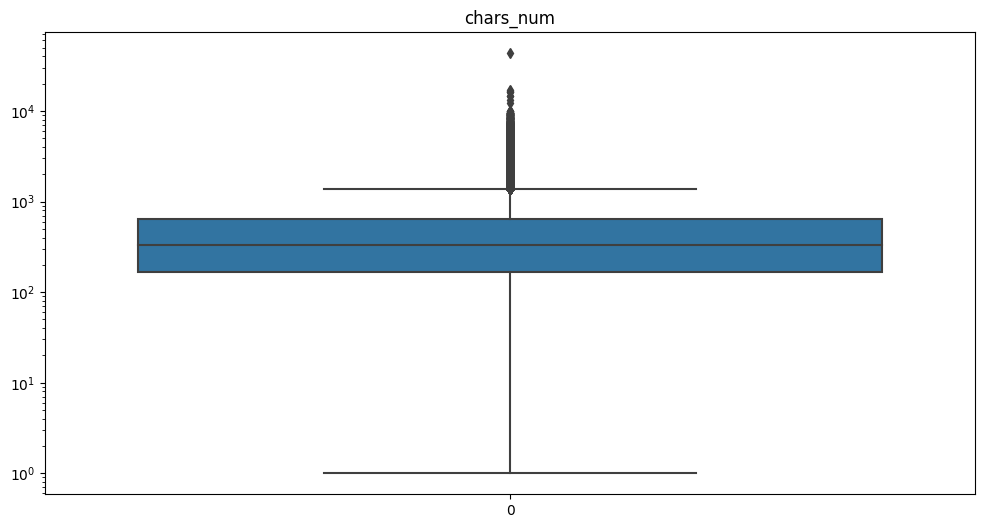

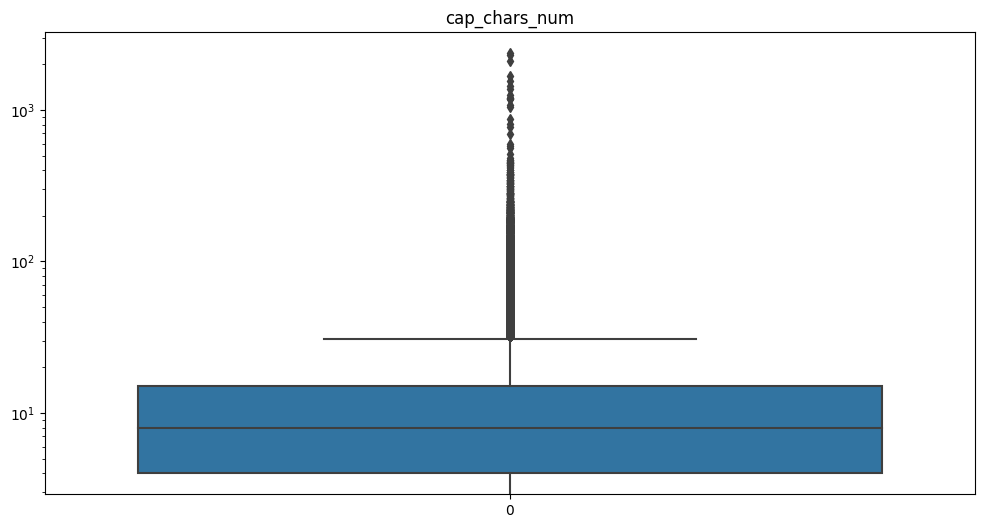

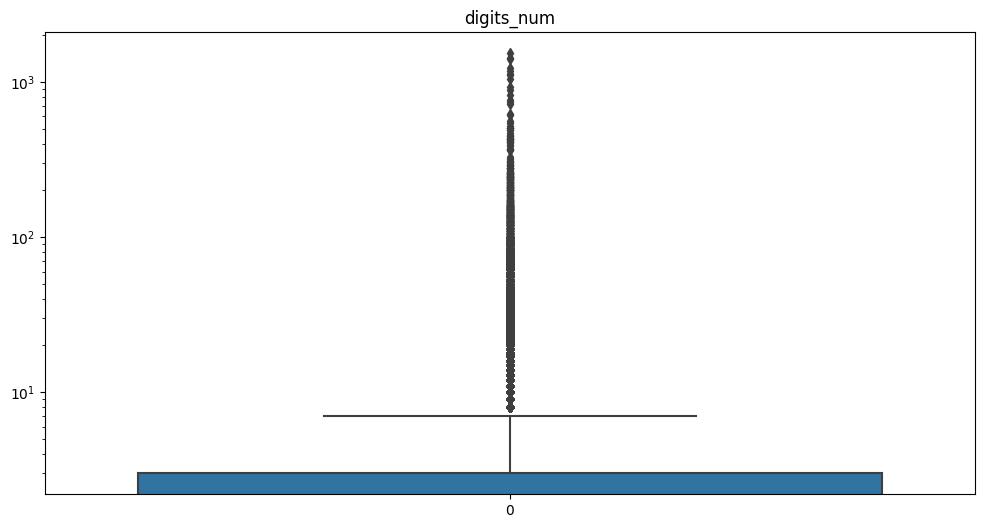

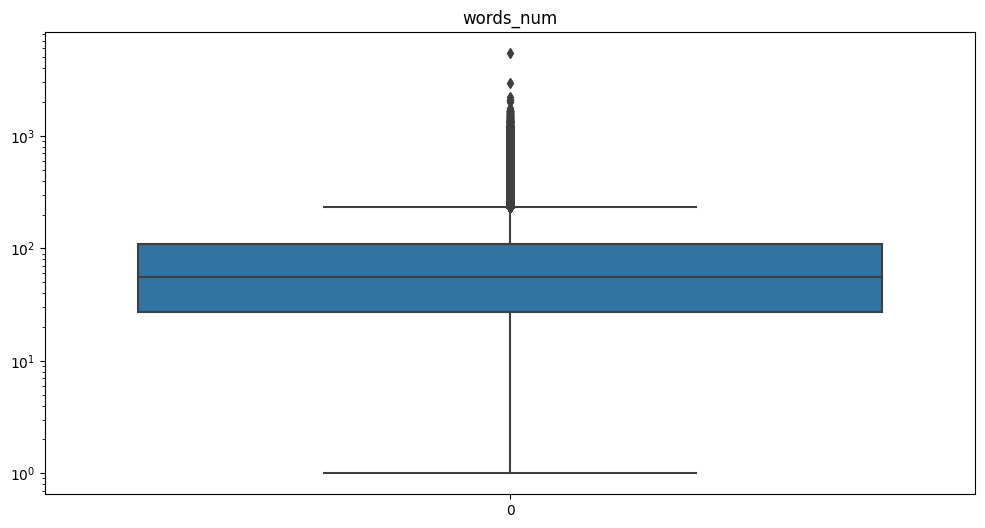

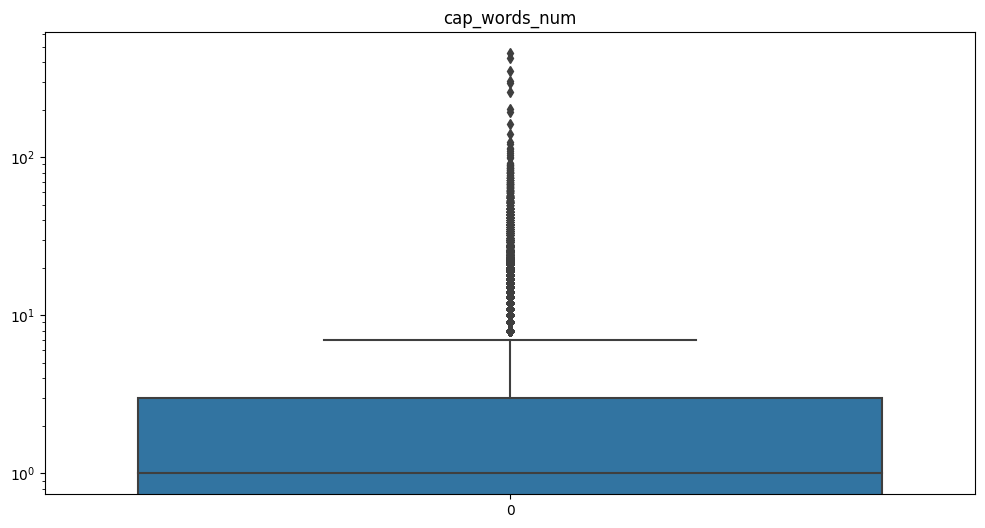

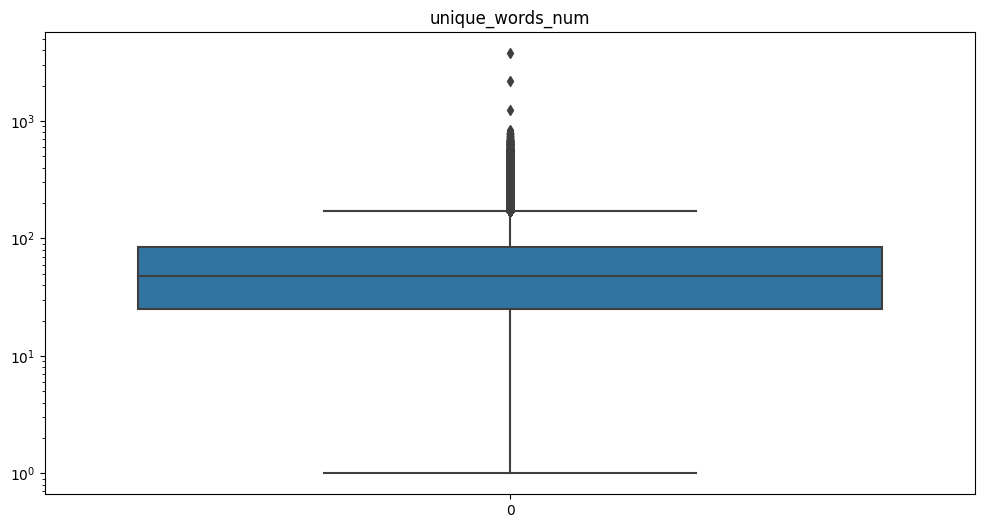

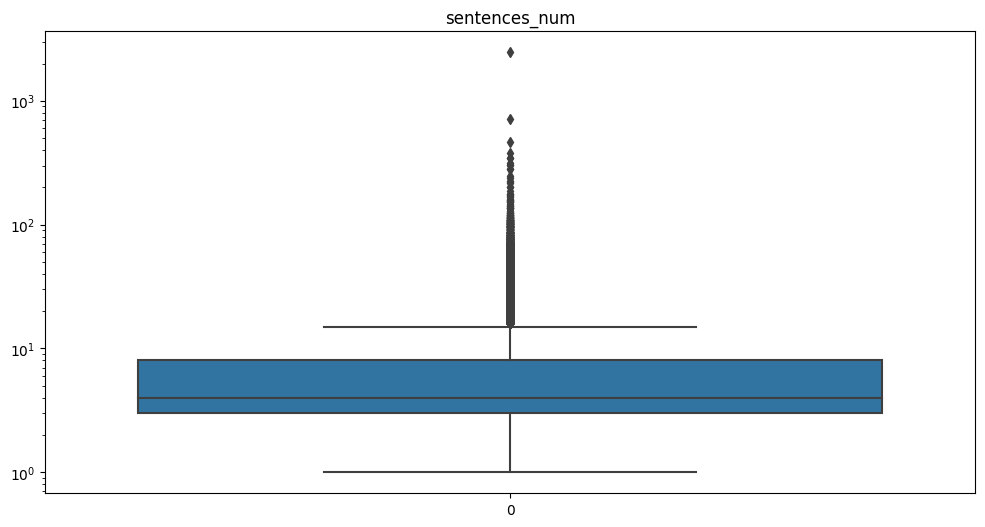

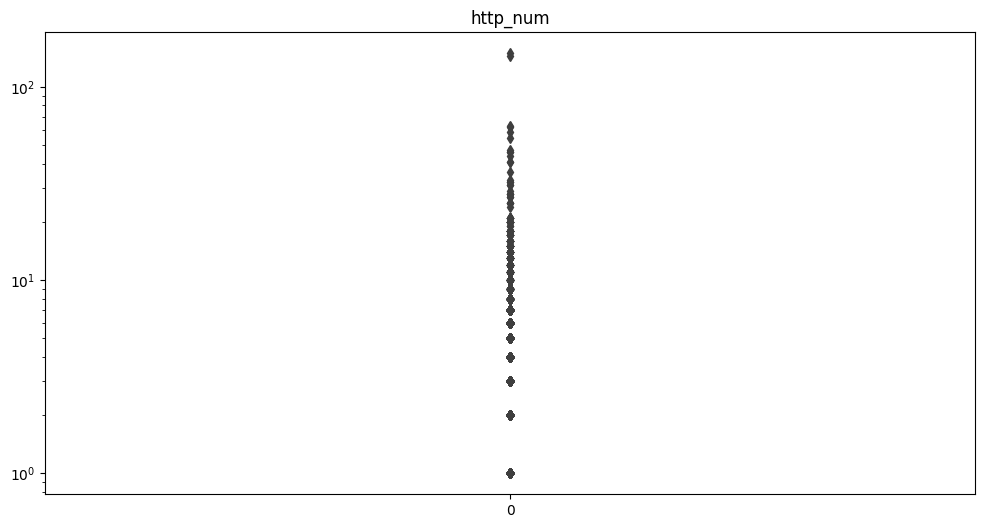

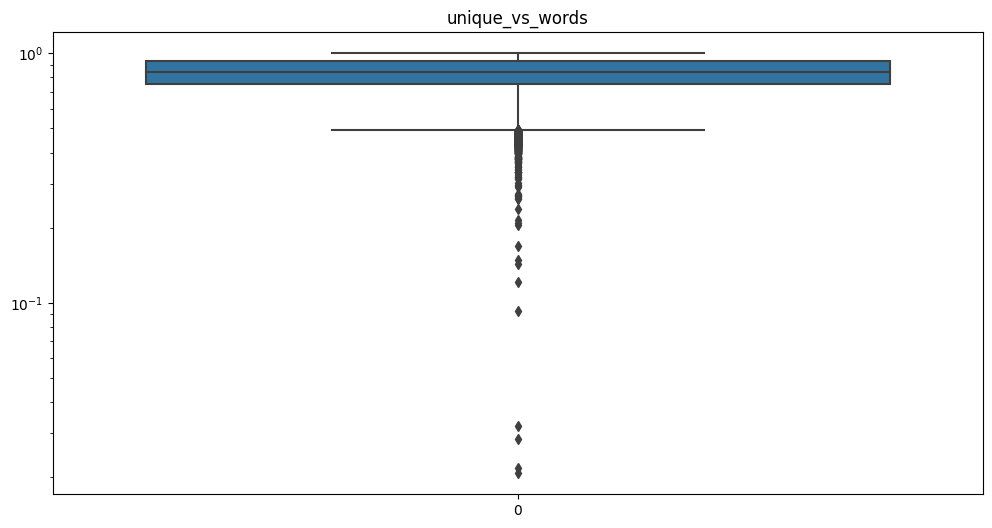

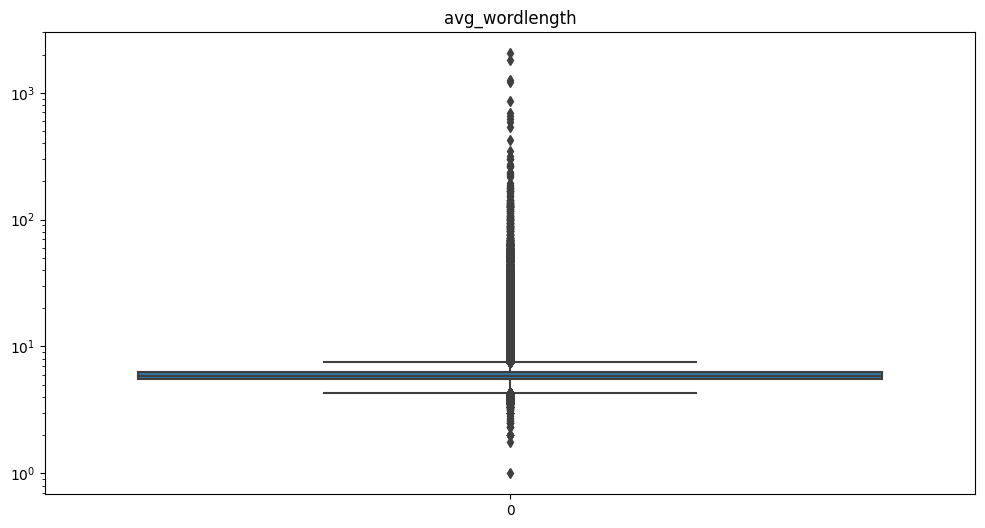

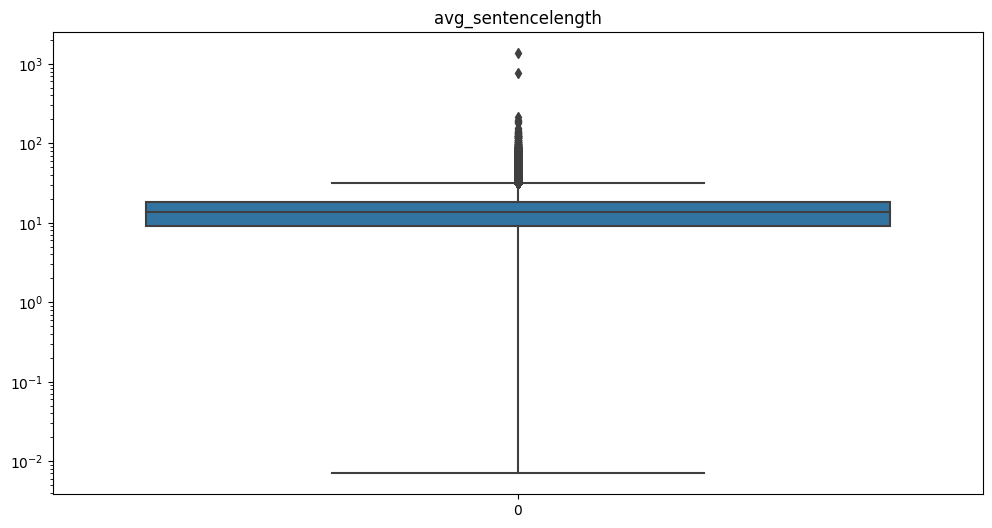

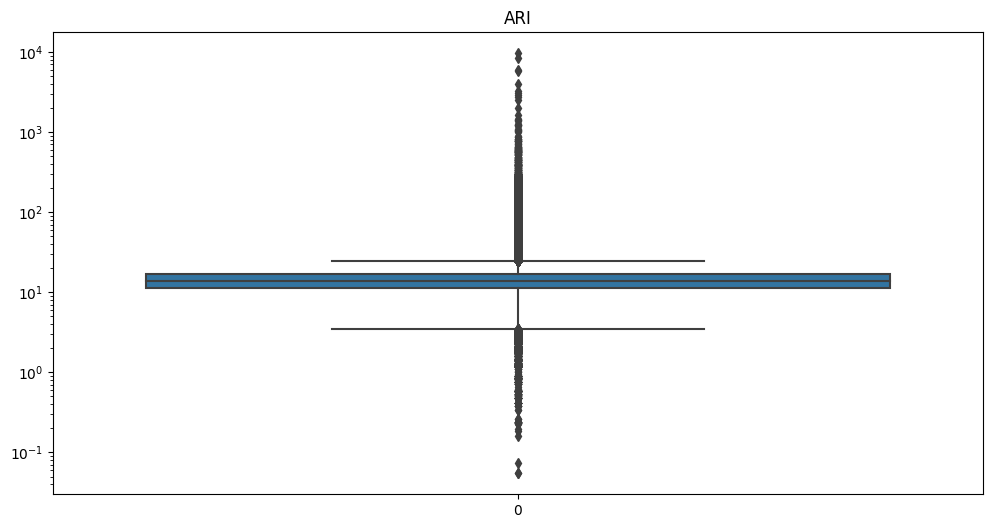

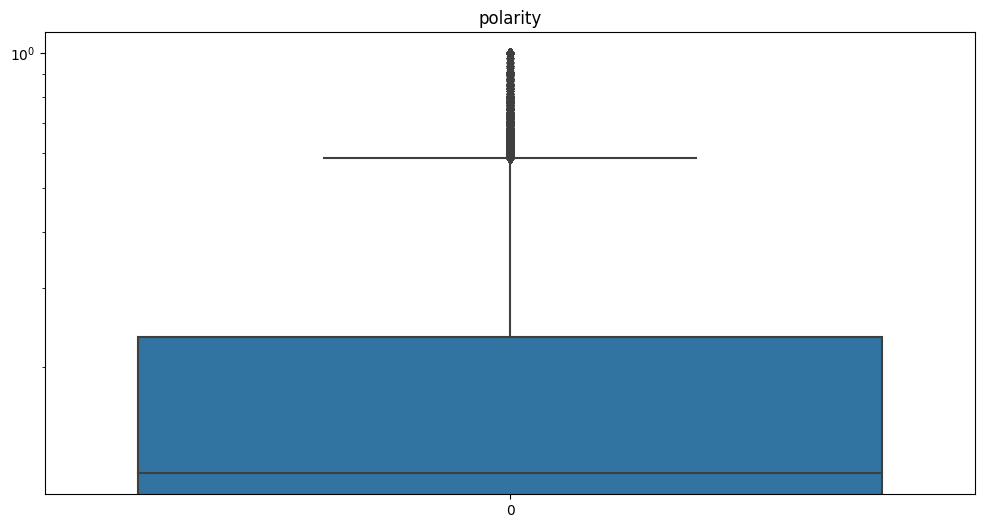

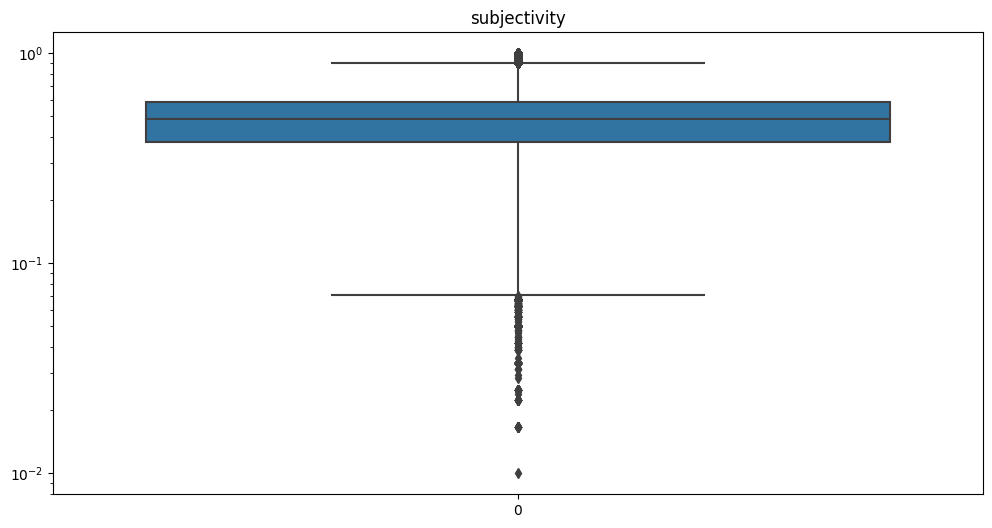

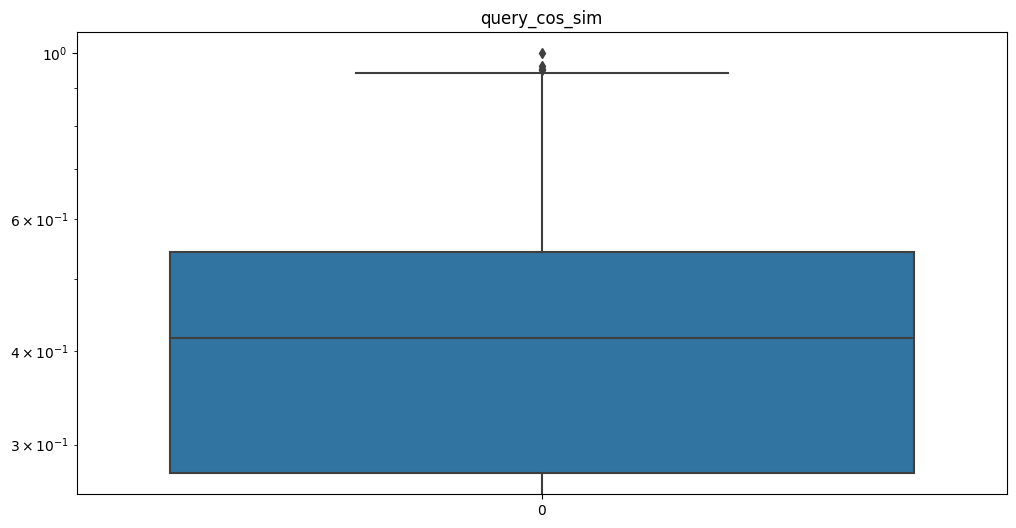

In [18]:
''' boxplots for feature values '''
for feature_name in features_df.columns:
    plt.figure(figsize=(12,6))
    feature = np.array(features_df[feature_name])
    p = sns.boxplot(feature)
    p.set_title(feature_name)
    p.set(yscale="log")
    plt.savefig(f'{data_dir}/plots/boxplot_features/{feature_name}.png')

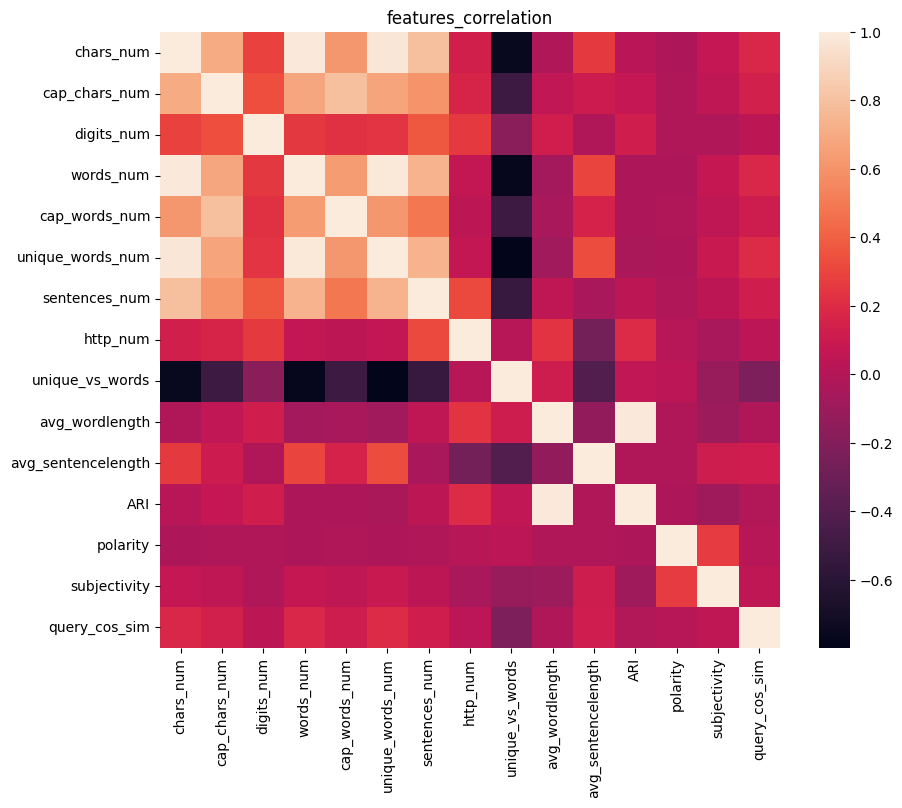

In [21]:
''' feature correlation matrix '''
plt.figure(figsize=(10,8))
feature = np.array(features_df[feature_name])
p = sns.heatmap(features_df.corr())
p.set_title("features_correlation")
plt.savefig(f'{data_dir}/plots/feature_corr.png')

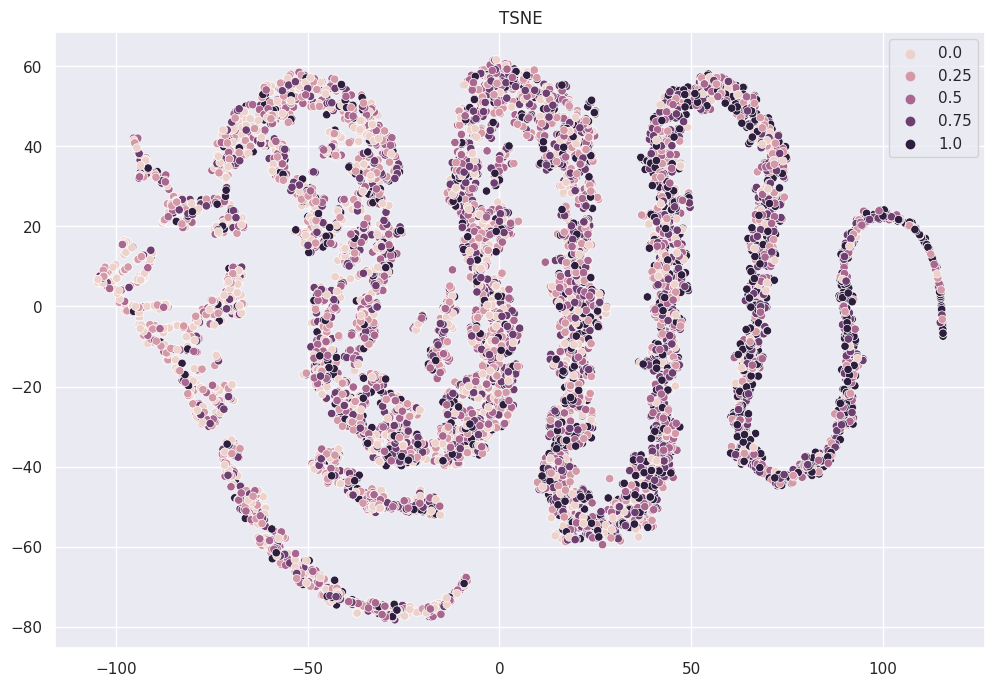

In [ ]:
from sklearn.manifold import TSNE
embedded = TSNE().fit_transform(features_df.to_numpy()[:10000,:])

plt.figure(figsize=(12,8))
scores = torch.load(f'{data_dir}/scores.pt').numpy()
p = sns.scatterplot(x=embedded[:,0], y=embedded[:,1], hue=scores[:embedded.shape[0]], legend='full')
p.set_title('TSNE')
plt.savefig(f'{data_dir}/plots/TSNE.png')